# Convolutional Neural Networks

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.


## Convolutional Networks: A brief historical context

![ImageNet Accuracy by Yearh](https://github.com/clarexie98/ai-science-training-series/blob/main/03_advanced_neural_networks/ImageNet.png?raw=1)

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [1]:
import torch, torchvision



# Convolutional Building Blocks

We're going to go through some examples of building blocks for convolutional networks.  To help illustate some of these, let's use an image for examples:


In [2]:
from PIL import Image
alcf_image = Image.open("ALCF-Staff.jpg")



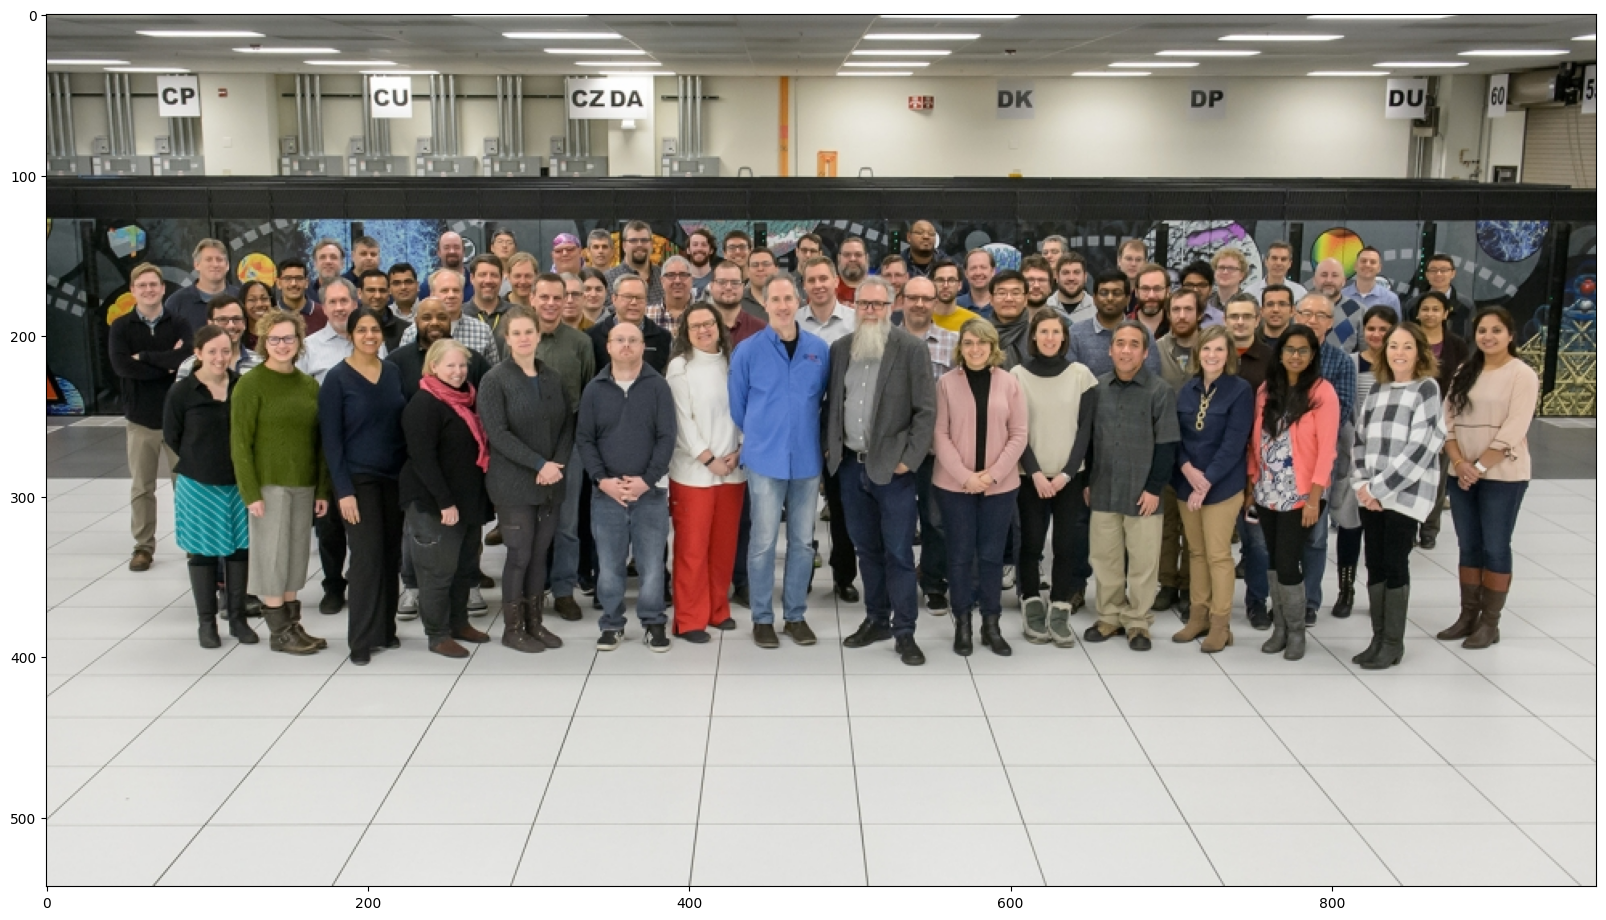

In [3]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()



## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

![image-2.png](attachment:image-2.png)

![image.png](attachment:image.png)


torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


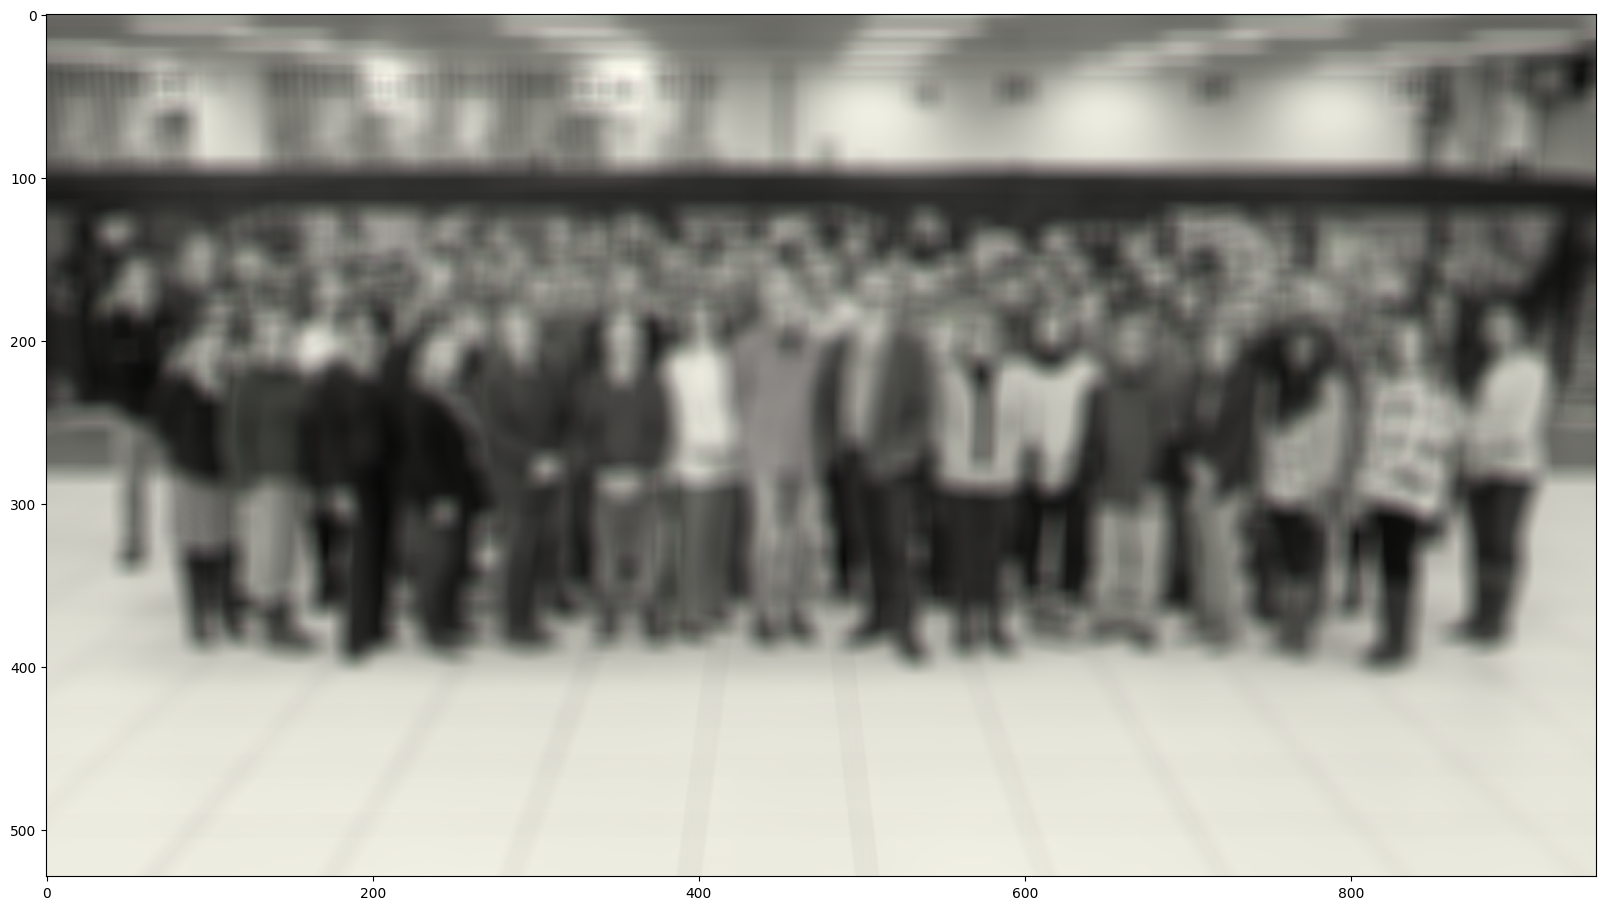

In [4]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)




## Normalization

![Batch Norm](https://github.com/clarexie98/ai-science-training-series/blob/main/03_advanced_neural_networks/batch_norm.png?raw=1)
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

![Batch Normalization accelerates training](https://github.com/clarexie98/ai-science-training-series/blob/main/03_advanced_neural_networks/batch_norm_effect.png?raw=1)

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)


torch.Size([1, 3, 543, 965])


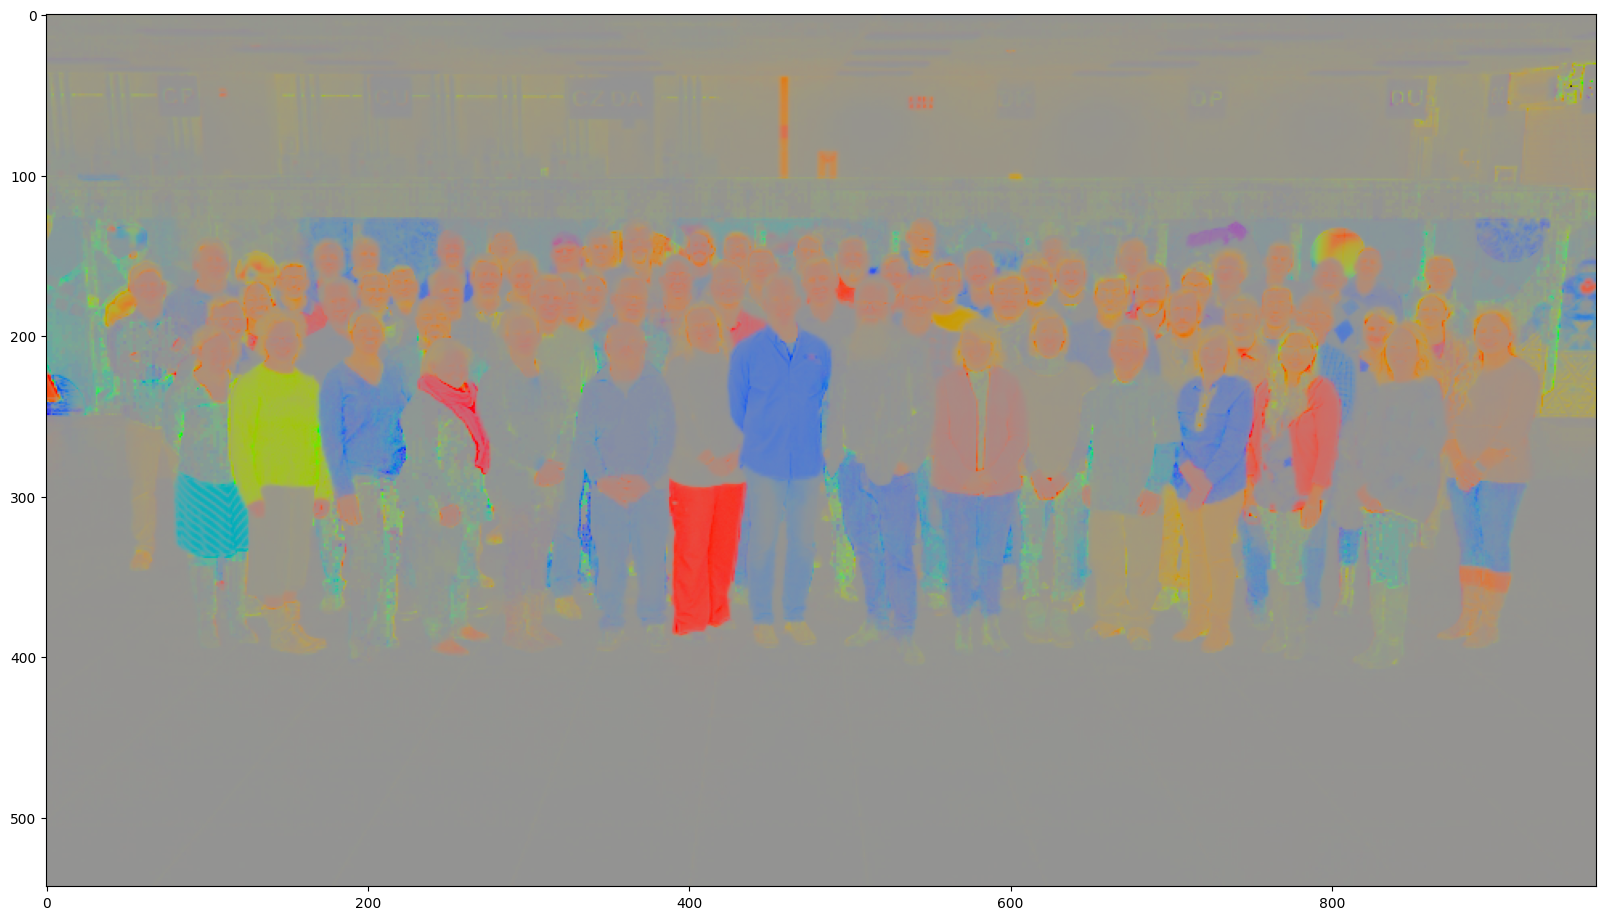

In [5]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)




## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

![Convolutional Pooling](conv_pooling.png "Pooling")

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



torch.Size([1, 3, 543, 965])


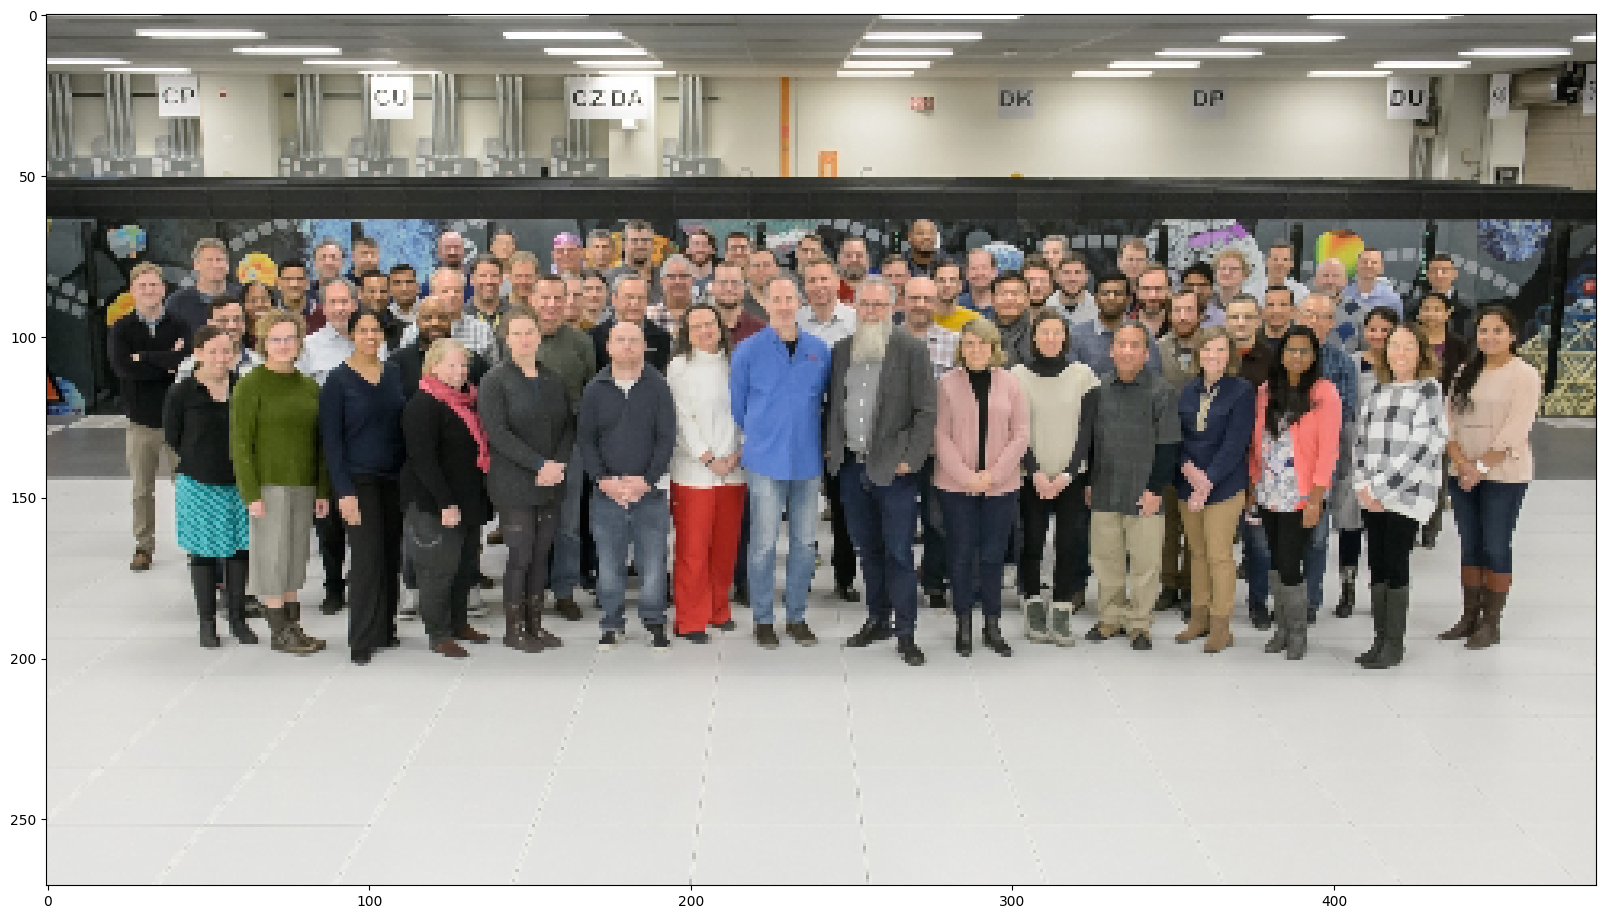

In [6]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)



## Residual Connections

One issue, quickly encountered when making convolutional networks deeper and deeper, is the "Vanishing Gradients" problem.  As layers were stacked on top of each other, the size of updates dimished at the earlier layers of a convolutional network.  The paper "Deep Residual Learning for Image Recognition" solved this by introduction "residual connections" as skip layers.


Reference: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

![Residual Layer](https://github.com/clarexie98/ai-science-training-series/blob/main/03_advanced_neural_networks/residual_layer.png?raw=1)


Compare the performance of the models before and after the introduction of these layers:

![Resnet Performance vs. Plain network performance](https://github.com/clarexie98/ai-science-training-series/blob/main/03_advanced_neural_networks/resnet_comparison.png?raw=1)

If you have time to read only one paper on computer vision, make it this one!  Resnet was the first model to beat human accuracy on ImageNet and is one of the most impactful papers in AI ever published.

# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [7]:

from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=4)



/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline



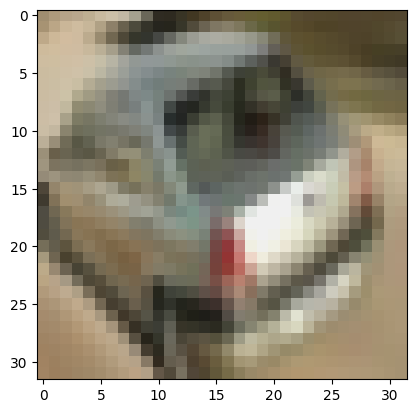

In [9]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()



This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)



In [11]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))



In [12]:
model = Classifier(64, 4, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))



Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-6               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-7                  [128, 256, 32,

In [13]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss



In [14]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()



In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)



In [16]:
from tqdm.notebook import tqdm


epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")




Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.620, accuracy: 41.249


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.608, accuracy: 41.772


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.364, accuracy: 50.292


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.385, accuracy: 48.606


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.190, accuracy: 57.451


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.213, accuracy: 55.409


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.095, accuracy: 60.982


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.166, accuracy: 57.684


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.961, accuracy: 66.152


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.048, accuracy: 62.441


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.808, accuracy: 71.436


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.957, accuracy: 65.833


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.712, accuracy: 75.047


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.887, accuracy: 68.048


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.612, accuracy: 78.599


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.842, accuracy: 70.016


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.519, accuracy: 82.308


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.789, accuracy: 71.826


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.451, accuracy: 84.435


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.808, accuracy: 72.538


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.396, accuracy: 86.621


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.783, accuracy: 73.170


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.354, accuracy: 87.872


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.821, accuracy: 72.805


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.277, accuracy: 90.618


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.765, accuracy: 74.357


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.262, accuracy: 91.052


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.816, accuracy: 74.693


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.232, accuracy: 92.160


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.783, accuracy: 74.654


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.194, accuracy: 93.458


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.809, accuracy: 75.277


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.172, accuracy: 94.139


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.833, accuracy: 75.643


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.156, accuracy: 94.713


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.839, accuracy: 75.583


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.150, accuracy: 94.746


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.828, accuracy: 76.019


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.152, accuracy: 94.688


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.902, accuracy: 75.465


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.129, accuracy: 95.452


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.849, accuracy: 76.503


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.144, accuracy: 94.976


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.925, accuracy: 75.425


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.108, accuracy: 96.116


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.907, accuracy: 76.701


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.118, accuracy: 95.724


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.913, accuracy: 77.245


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.109, accuracy: 96.116


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.937, accuracy: 76.345


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.104, accuracy: 96.273


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.935, accuracy: 77.027


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.110, accuracy: 96.091


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.982, accuracy: 76.206


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.101, accuracy: 96.388


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.948, accuracy: 76.553


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.069, accuracy: 97.531


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.886, accuracy: 77.729


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.084, accuracy: 97.070


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.933, accuracy: 76.988


# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

Starting by trying around. 

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

class ModifiedConvNet(nn.Module):
    def __init__(self):
        super(ModifiedConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        output = self.fc2(x)
        return output

# Assuming the dataloaders, train_dataloader and val_dataloader are already defined

model = ModifiedConvNet()
model.cuda()

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
loss_fn = nn.CrossEntropyLoss()

from tqdm.notebook import tqdm


epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.421, accuracy: 47.599


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.424, accuracy: 48.190


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.133, accuracy: 59.924


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.131, accuracy: 58.752


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.050, accuracy: 62.318


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.056, accuracy: 62.500


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.002, accuracy: 63.688


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.027, accuracy: 62.193


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.889, accuracy: 68.670


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.918, accuracy: 67.019


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.849, accuracy: 70.817


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.878, accuracy: 68.819


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.847, accuracy: 70.457


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.871, accuracy: 68.898


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.854, accuracy: 70.402


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.896, accuracy: 68.631


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.935, accuracy: 67.836


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.977, accuracy: 66.337


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.746, accuracy: 73.575


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.783, accuracy: 72.093


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.080, accuracy: 62.912


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.103, accuracy: 61.531


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.731, accuracy: 75.027


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.772, accuracy: 73.121


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.720, accuracy: 74.309


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.782, accuracy: 71.697


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.675, accuracy: 76.373


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.736, accuracy: 73.556


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.722, accuracy: 74.608


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.773, accuracy: 72.567


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.658, accuracy: 76.997


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.708, accuracy: 75.099


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.660, accuracy: 76.917


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.708, accuracy: 74.436


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.552, accuracy: 80.816


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.640, accuracy: 77.551


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.573, accuracy: 80.307


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.635, accuracy: 77.433


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.678, accuracy: 76.148


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.760, accuracy: 73.616


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.799, accuracy: 73.797


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.886, accuracy: 71.183


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.627, accuracy: 78.212


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.716, accuracy: 74.832


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.736, accuracy: 74.381


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.799, accuracy: 72.182


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.558, accuracy: 80.297


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.652, accuracy: 76.741


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.491, accuracy: 83.139


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.590, accuracy: 79.361


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.552, accuracy: 81.387


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.636, accuracy: 77.492


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.481, accuracy: 83.437


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.593, accuracy: 78.778


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.507, accuracy: 82.486


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.614, accuracy: 78.105


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.670, accuracy: 76.984


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.750, accuracy: 73.210


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.477, accuracy: 83.649


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.587, accuracy: 79.045


Increased Number of Filters: Starting with 64 filters and doubling them after each downsampling increases the model's capacity to learn more complex features.
Dropout and Batch Normalization: These are added as regularizers to help combat overfitting. Dropout is applied before the fully connected layers, and batch normalization is applied after each convolutional layer.
Learning Rate Scheduler: Decreases the learning rate as epochs progress, allowing for finer adjustments to the weights as the training process matures.
By implementing these modifications, you're likely to see improvements in validation accuracy and a reduction in overfitting. The dropout and batch normalization help the model generalize better to unseen data, while the increased number of filters allows the network to learn a richer set of features. Remember, the effectiveness of these changes can vary based on many factors, so it's important to experiment and adjust based on the results you observe.

# Alternative Method
We will increase the number of filters progressively as the network deepens, which is a common practice to compensate for the reduced spatial dimensions after pooling layers.

In [20]:
class ModifiedConvNet(nn.Module):
    def __init__(self):
        super(ModifiedConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Reduced from 64 to 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Increased to 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Increased to 128
        self.fc1 = nn.Linear(128*4*4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [22]:
model = ModifiedConvNet()
model.cuda()

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
loss_fn = nn.CrossEntropyLoss()

from tqdm.notebook import tqdm


epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.502, accuracy: 44.981


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.491, accuracy: 45.036


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.233, accuracy: 55.741


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.238, accuracy: 54.420


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.146, accuracy: 59.158


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.154, accuracy: 58.089


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.018, accuracy: 63.868


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.039, accuracy: 62.371


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.021, accuracy: 63.196


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.063, accuracy: 60.997


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.890, accuracy: 69.526


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.933, accuracy: 66.802


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.836, accuracy: 70.714


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.897, accuracy: 68.068


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.805, accuracy: 71.882


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.860, accuracy: 69.155


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.747, accuracy: 73.702


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.814, accuracy: 70.748


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.732, accuracy: 74.186


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.819, accuracy: 70.589


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.701, accuracy: 75.032


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.798, accuracy: 71.420


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.655, accuracy: 76.865


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.764, accuracy: 72.419


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.651, accuracy: 77.072


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.766, accuracy: 72.696


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.617, accuracy: 78.502


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.736, accuracy: 73.665


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.587, accuracy: 79.248


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.728, accuracy: 74.209


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.587, accuracy: 79.468


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.720, accuracy: 74.150


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.572, accuracy: 80.012


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.708, accuracy: 74.387


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.579, accuracy: 79.525


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.715, accuracy: 74.031


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.565, accuracy: 80.034


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.717, accuracy: 74.061


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.541, accuracy: 81.030


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.699, accuracy: 75.247


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.521, accuracy: 81.704


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.710, accuracy: 75.010


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.518, accuracy: 81.956


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.699, accuracy: 74.782


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.487, accuracy: 83.062


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.671, accuracy: 76.048


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.508, accuracy: 82.119


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.717, accuracy: 74.763


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.469, accuracy: 83.471


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.660, accuracy: 77.008


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.460, accuracy: 84.016


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.657, accuracy: 76.642


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.449, accuracy: 84.168


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.668, accuracy: 76.404


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.448, accuracy: 84.178


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.667, accuracy: 76.750


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.456, accuracy: 84.288


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.664, accuracy: 76.968


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.418, accuracy: 85.309


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.664, accuracy: 76.938


In [37]:
class AdvancedConvNet(nn.Module):
    def __init__(self):
        super(AdvancedConvNet, self).__init__()
        # Initial "patchify" layer: larger kernel size and stride
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)  # Simulating a patchify operation
        self.bn1 = nn.BatchNorm2d(64)
        # Increase the number of convolutions between downsampling
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Increase the number of filters and add an extra convolution before downsampling
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        #self.fc1 = nn.Linear(256*4*4, 512)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # Downsampling
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))  # Additional convolution
        x = F.max_pool2d(x, 2)  # Downsampling
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))  # Additional convolution
        x = F.max_pool2d(x, 2)  # Downsampling
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = AdvancedConvNet()
model.cuda()

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
loss_fn = nn.CrossEntropyLoss()

from tqdm.notebook import tqdm

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.342, accuracy: 52.421


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.349, accuracy: 51.652


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.111, accuracy: 60.446


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.129, accuracy: 59.148


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 0.909, accuracy: 68.044


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 0.969, accuracy: 65.763


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 0.900, accuracy: 68.126


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.966, accuracy: 65.754


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.896, accuracy: 68.523


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.962, accuracy: 65.585


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.644, accuracy: 77.638


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.752, accuracy: 73.398


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.587, accuracy: 79.553


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.705, accuracy: 75.405


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.822, accuracy: 73.160


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.976, accuracy: 68.879


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.669, accuracy: 76.425


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.836, accuracy: 71.608


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.680, accuracy: 76.470


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.839, accuracy: 71.361


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.641, accuracy: 78.834


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.824, accuracy: 73.269


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.401, accuracy: 85.551


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.622, accuracy: 77.917


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.673, accuracy: 76.637


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.877, accuracy: 71.549


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.426, accuracy: 85.234


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.698, accuracy: 77.097


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.358, accuracy: 87.298


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.619, accuracy: 78.313


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.480, accuracy: 83.404


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.777, accuracy: 74.812


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.309, accuracy: 88.808


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.660, accuracy: 78.550


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.398, accuracy: 85.571


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.724, accuracy: 76.642


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.421, accuracy: 85.553


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.782, accuracy: 75.682


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.261, accuracy: 90.720


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.666, accuracy: 78.728


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.284, accuracy: 90.151


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.706, accuracy: 77.917


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.258, accuracy: 90.925


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.692, accuracy: 78.699


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.467, accuracy: 84.837


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.907, accuracy: 74.565


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.309, accuracy: 89.282


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.771, accuracy: 77.769


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.245, accuracy: 91.334


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.744, accuracy: 78.441


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.309, accuracy: 89.210


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.809, accuracy: 76.543


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.214, accuracy: 92.290


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.689, accuracy: 79.490


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.230, accuracy: 91.808


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.763, accuracy: 78.748


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.216, accuracy: 92.504


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.804, accuracy: 78.273


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.151, accuracy: 94.559


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.733, accuracy: 80.123


In [38]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # Evaluate on training dataset
    train_acc, train_loss = evaluate(train_dataloader, model, loss_fn, train_bar)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate on validation dataset
    val_acc, val_loss = evaluate(val_dataloader, model, loss_fn, val_bar)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {j}: Training Loss: {train_loss:.3f}, Training Accuracy: {train_acc:.3f}%")
    print(f"Epoch {j}: Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.3f}%")


Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: Training Loss: 0.147, Training Accuracy: 94.786%
Epoch 0: Validation Loss: 0.714, Validation Accuracy: 80.894%


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: Training Loss: 0.375, Training Accuracy: 87.859%
Epoch 1: Validation Loss: 0.960, Validation Accuracy: 76.058%


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.183, Training Accuracy: 93.463%
Epoch 2: Validation Loss: 0.805, Validation Accuracy: 78.857%


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.147, Training Accuracy: 94.748%
Epoch 3: Validation Loss: 0.769, Validation Accuracy: 79.233%


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.140, Training Accuracy: 95.000%
Epoch 4: Validation Loss: 0.773, Validation Accuracy: 79.945%


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: Training Loss: 0.127, Training Accuracy: 95.415%
Epoch 5: Validation Loss: 0.712, Validation Accuracy: 80.538%


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: Training Loss: 0.201, Training Accuracy: 92.856%
Epoch 6: Validation Loss: 0.784, Validation Accuracy: 79.242%


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: Training Loss: 0.200, Training Accuracy: 92.891%
Epoch 7: Validation Loss: 0.844, Validation Accuracy: 77.977%


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: Training Loss: 0.151, Training Accuracy: 94.519%
Epoch 8: Validation Loss: 0.763, Validation Accuracy: 79.875%


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: Training Loss: 0.128, Training Accuracy: 95.425%
Epoch 9: Validation Loss: 0.753, Validation Accuracy: 79.796%


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: Training Loss: 0.154, Training Accuracy: 94.609%
Epoch 10: Validation Loss: 0.807, Validation Accuracy: 79.183%


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: Training Loss: 0.096, Training Accuracy: 96.588%
Epoch 11: Validation Loss: 0.752, Validation Accuracy: 80.874%


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: Training Loss: 0.106, Training Accuracy: 96.226%
Epoch 12: Validation Loss: 0.759, Validation Accuracy: 80.914%


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: Training Loss: 0.154, Training Accuracy: 94.624%
Epoch 13: Validation Loss: 0.791, Validation Accuracy: 79.964%


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: Training Loss: 0.139, Training Accuracy: 95.035%
Epoch 14: Validation Loss: 0.823, Validation Accuracy: 79.391%


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: Training Loss: 0.120, Training Accuracy: 95.652%
Epoch 15: Validation Loss: 0.783, Validation Accuracy: 80.320%


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: Training Loss: 0.156, Training Accuracy: 94.566%
Epoch 16: Validation Loss: 0.872, Validation Accuracy: 79.688%


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: Training Loss: 0.128, Training Accuracy: 95.512%
Epoch 17: Validation Loss: 0.829, Validation Accuracy: 79.984%


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: Training Loss: 0.094, Training Accuracy: 96.678%
Epoch 18: Validation Loss: 0.755, Validation Accuracy: 81.023%


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: Training Loss: 0.092, Training Accuracy: 96.688%
Epoch 19: Validation Loss: 0.751, Validation Accuracy: 81.477%


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: Training Loss: 0.114, Training Accuracy: 95.862%
Epoch 20: Validation Loss: 0.819, Validation Accuracy: 80.212%


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: Training Loss: 0.107, Training Accuracy: 96.081%
Epoch 21: Validation Loss: 0.783, Validation Accuracy: 80.311%


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: Training Loss: 0.133, Training Accuracy: 95.322%
Epoch 22: Validation Loss: 0.838, Validation Accuracy: 79.430%


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: Training Loss: 0.108, Training Accuracy: 95.991%
Epoch 23: Validation Loss: 0.781, Validation Accuracy: 80.469%


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: Training Loss: 0.105, Training Accuracy: 96.141%
Epoch 24: Validation Loss: 0.823, Validation Accuracy: 80.212%


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: Training Loss: 0.296, Training Accuracy: 91.167%
Epoch 25: Validation Loss: 1.033, Validation Accuracy: 77.512%


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: Training Loss: 0.151, Training Accuracy: 94.738%
Epoch 26: Validation Loss: 0.872, Validation Accuracy: 78.916%


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: Training Loss: 0.184, Training Accuracy: 93.745%
Epoch 27: Validation Loss: 0.931, Validation Accuracy: 78.560%


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: Training Loss: 0.093, Training Accuracy: 96.625%
Epoch 28: Validation Loss: 0.820, Validation Accuracy: 80.103%


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: Training Loss: 0.118, Training Accuracy: 95.784%
Epoch 29: Validation Loss: 0.839, Validation Accuracy: 80.053%


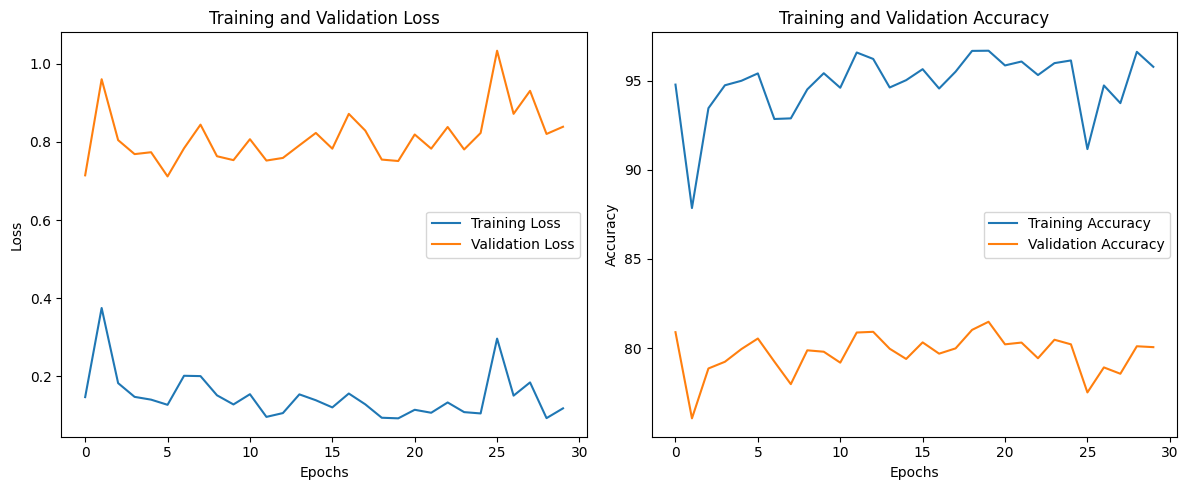

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Explanation of Network Changes and Their Impact
Changes made to the AdvancedConvNet architecture include:

Initial "Patchify" Layer: The first convolutional layer was modified to have a larger kernel size (5x5) and stride (2), effectively acting as a patchify operation. This allows the network to initially process the input image in larger patches, potentially capturing more global contextual information early in the feature extraction process. This can lead to improved feature representation, especially for distinguishing between different classes in CIFAR-10.

Increased Number of Convolutions Between Downsampling: Additional convolutional layers were added between downsampling steps. This increases the depth of the network, allowing it to learn more complex features before each spatial reduction. It can improve the network's ability to differentiate between similar classes by focusing on finer details.

Increased Number of Filters: The number of filters was increased in deeper convolutional layers. This expansion of the network's width allows it to represent a broader range of features at each level of abstraction. More filters can capture more varied aspects of the input images, potentially leading to better classification accuracy.

Adjustment in the Fully Connected Layer: The input size of the first fully connected layer (self.fc1) was corrected to match the flattened size of the preceding layer's output. This adjustment ensures that the network's architecture is coherent, allowing for proper forward propagation of activations without shape mismatches.

These changes collectively aim to enhance the network's feature extraction capabilities and its overall capacity to learn from the CIFAR-10 dataset. By increasing both the depth (with more convolutional layers) and the width (with more filters) of the network, we expect to see improved performance in terms of validation accuracy, potentially at the cost of increased computational complexity. The "patchify" operation at the beginning is particularly innovative, as it tries to incorporate a form of attention to larger spatial areas early in the network, which could make a significant difference in how the network perceives and processes the input images.